In [ ]:
pip install numpy pandas yfinance cvxopt matplotlib


[*********************100%%**********************]  4 of 4 completed


Stock Prices:
 Ticker           AAPL       AMZN      GOOGL        MSFT
Date                                                   
2020-01-02  72.960472  94.900497  68.355545  154.215652
2020-01-03  72.251144  93.748497  67.997955  152.295425
2020-01-06  72.826859  95.143997  69.810379  152.689072
2020-01-07  72.484344  95.343002  69.675537  151.296875
2020-01-08  73.650352  94.598503  70.171463  153.706772
Daily Returns:
 Ticker          AAPL      AMZN     GOOGL      MSFT
Date                                              
2020-01-03 -0.009722 -0.012139 -0.005231 -0.012452
2020-01-06  0.007968  0.014886  0.026654  0.002585
2020-01-07 -0.004703  0.002092 -0.001932 -0.009118
2020-01-08  0.016086 -0.007809  0.007118  0.015928
2020-01-09  0.021241  0.004799  0.010498  0.012493
     pcost       dcost       gap    pres   dres
 0:  2.0937e-04 -9.9981e-01  1e+00  2e-16  3e+00
 1:  2.0937e-04 -9.8089e-03  1e-02  1e-16  3e-02
 2:  2.0934e-04  9.1182e-05  1e-04  1e-16  3e-04
 3:  2.0813e-04  1.9704e-

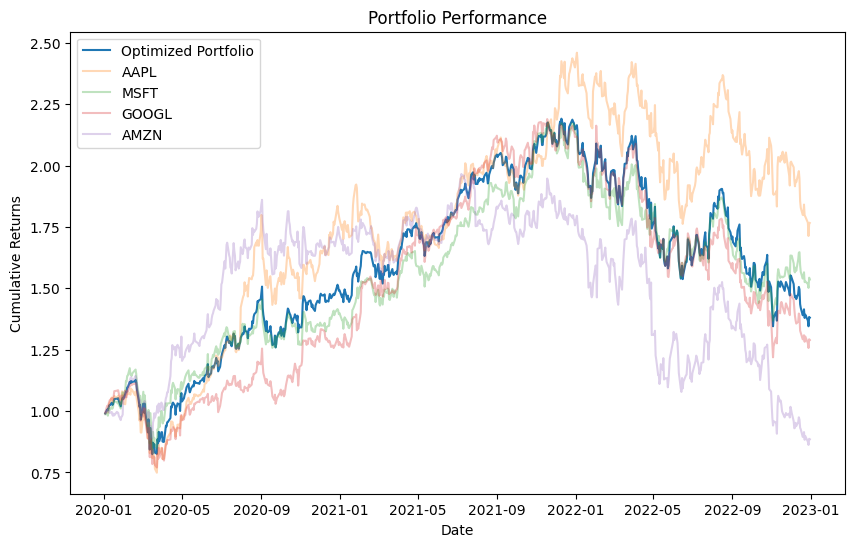

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Define the stock tickers and the time period
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetch the stock data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Display the first few rows of the data
print("Stock Prices:\n", data.head())

# Calculate daily returns
returns = data.pct_change().dropna()

# Display the first few rows of the returns
print("Daily Returns:\n", returns.head())

# Calculate the mean returns and the covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Convert to cvxopt matrices
P = matrix(cov_matrix.values)
q = matrix(np.zeros(len(tickers)))

# Constraints Gx <= h (short-selling not allowed)
G = matrix(-np.identity(len(tickers)))
h = matrix(np.zeros(len(tickers)))

# Constraint Ax = b (weights sum to 1)
A = matrix(1.0, (1, len(tickers)))
b = matrix(1.0)

# Solve the optimization problem
sol = solvers.qp(P, q, G, h, A, b)

# Extract the optimal weights
optimal_weights = np.array(sol['x']).flatten()

# Display the optimal weights
optimal_weights_df = pd.DataFrame(optimal_weights, index=tickers, columns=['Weight'])
print("Optimal Weights:\n", optimal_weights_df)

# Calculate portfolio expected return and variance
portfolio_return = np.dot(mean_returns, optimal_weights)
portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))

print(f"Expected Portfolio Return: {portfolio_return}")
print(f"Portfolio Variance: {portfolio_variance}")

# Plot the portfolio performance
# Calculate cumulative returns of the portfolio
portfolio_cumulative_returns = (returns.dot(optimal_weights) + 1).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns, label='Optimized Portfolio')
for ticker in tickers:
    plt.plot((returns[ticker] + 1).cumprod(), label=ticker, alpha=0.3)
plt.legend()
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()


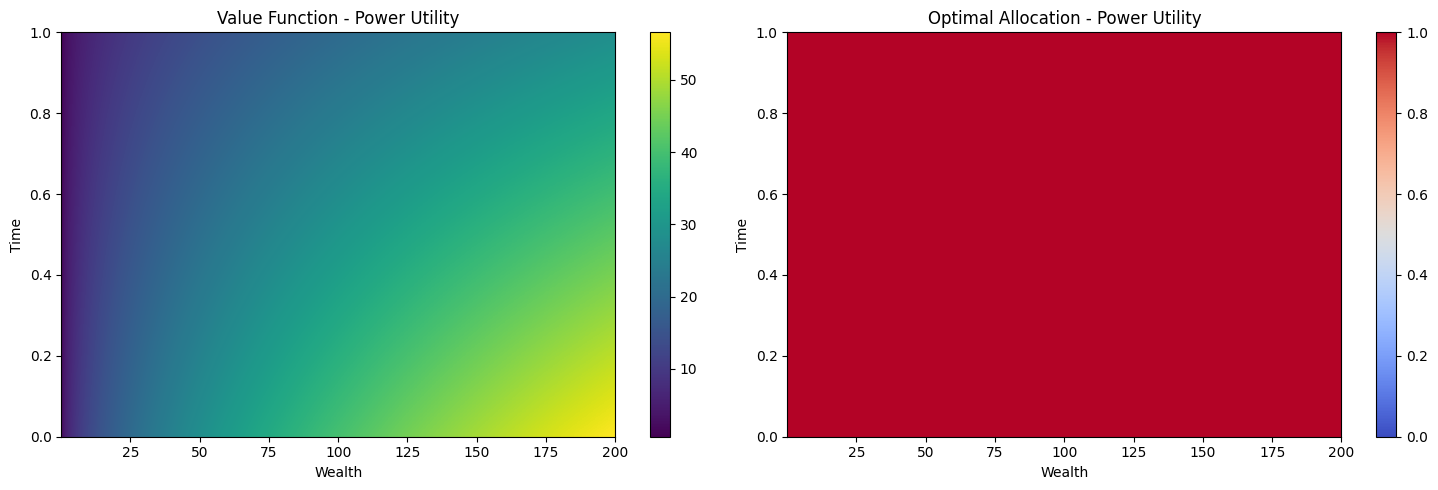

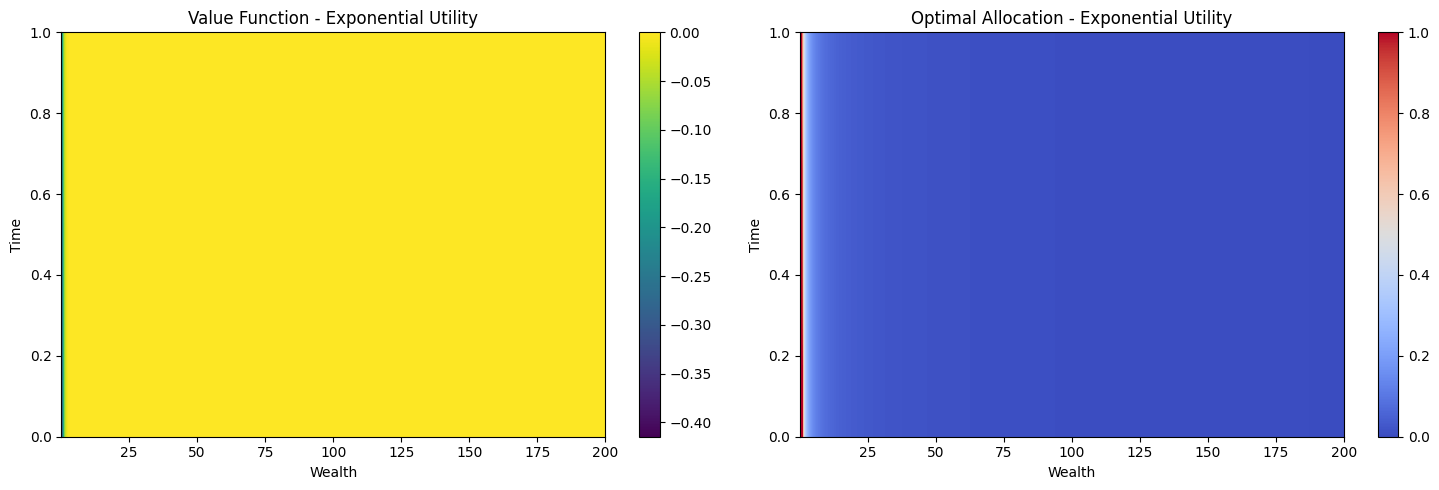

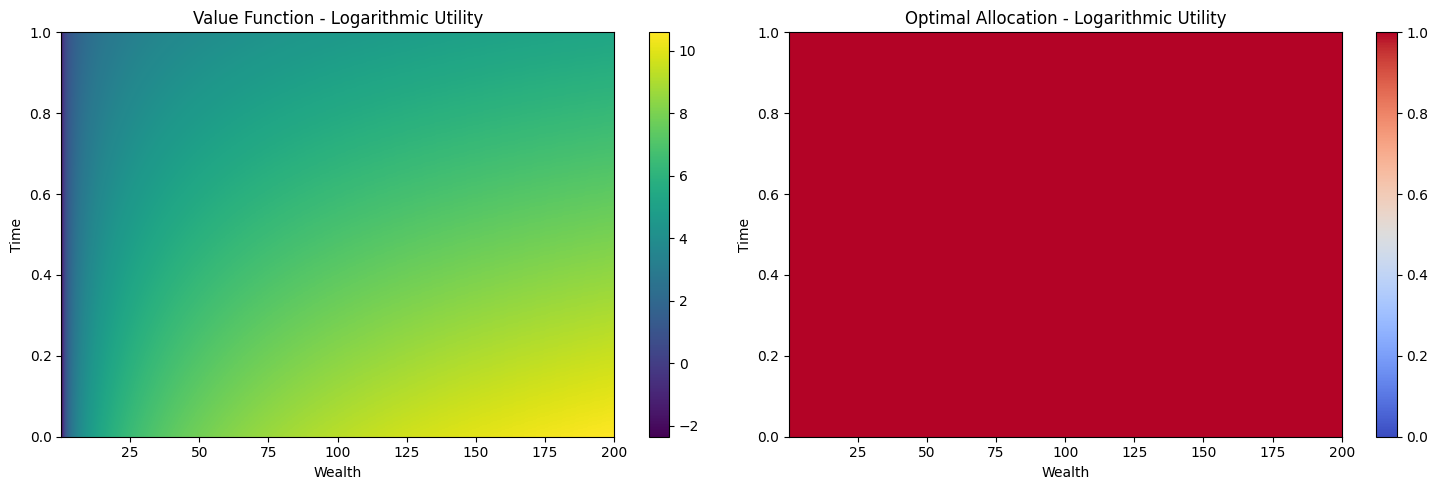

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import odeint

# 1. Stock price simulation
def simulate_stock_prices(S0, mu, sigma, T, dt, num_paths):
    """
    Simulate stock prices using Geometric Brownian Motion.

    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift
    sigma (float): Volatility
    T (float): Time horizon
    dt (float): Time step
    num_paths (int): Number of simulations

    Returns:
    numpy.ndarray: Simulated stock prices
    """
    num_steps = int(T / dt)
    times = np.linspace(0, T, num_steps)
    dW = np.random.normal(0, np.sqrt(dt), (num_paths, num_steps - 1))

    S = np.zeros((num_paths, num_steps))
    S[:, 0] = S0

    for t in range(1, num_steps):
        S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])

    return S, times

# 2. Markov-modulated drift process
class MarkovModulatedDrift:
    def __init__(self, states, transition_matrix):
        self.states = states
        self.transition_matrix = transition_matrix

    def simulate(self, T, dt):
        num_steps = int(T / dt)
        current_state = np.random.choice(len(self.states))
        drift_path = []

        for _ in range(num_steps):
            drift_path.append(self.states[current_state])
            current_state = np.random.choice(len(self.states), p=self.transition_matrix[current_state])

        return np.array(drift_path)

# 3. Utility functions
def power_utility(x, gamma):
    return x**(1 - gamma) / (1 - gamma) if gamma != 1 else np.log(x)

def exponential_utility(x, alpha):
    return -np.exp(-alpha * x) / alpha

def logarithmic_utility(x):
    return np.log(x)

# 4. HJB equation solver
def solve_hjb(utility_func, r, mu, sigma, T, x_range, t_range):
    """
    Solve the HJB equation for a given utility function.

    Parameters:
    utility_func (function): Utility function
    r (float): Risk-free rate
    mu (float): Drift
    sigma (float): Volatility
    T (float): Time horizon
    x_range (numpy.ndarray): Range of wealth values
    t_range (numpy.ndarray): Range of time values

    Returns:
    numpy.ndarray: Solution to the HJB equation
    """
    def hjb_pde(V, t, x, r, mu, sigma, utility_func):
        Vx = np.gradient(V, x)
        Vxx = np.gradient(Vx, x)

        theta = (mu - r) / (sigma**2)

        return -np.maximum(utility_func(x), r * x * Vx + 0.5 * theta**2 * x**2 * Vxx)

    V = np.zeros((len(t_range), len(x_range)))
    V[-1, :] = utility_func(x_range)

    for i in range(len(t_range) - 2, -1, -1):
        t = t_range[i]
        V[i, :] = odeint(hjb_pde, V[i+1, :], [t_range[i+1], t],
                         args=(x_range, r, mu, sigma, utility_func))[-1]

    return V

# 5. Portfolio optimization
def optimize_portfolio(V, x_range, t_range, r, mu, sigma):
    """
    Optimize portfolio allocation based on the HJB solution.

    Parameters:
    V (numpy.ndarray): Solution to the HJB equation
    x_range (numpy.ndarray): Range of wealth values
    t_range (numpy.ndarray): Range of time values
    r (float): Risk-free rate
    mu (float): Drift
    sigma (float): Volatility

    Returns:
    numpy.ndarray: Optimal portfolio allocation
    """
    Vx = np.gradient(V, x_range, axis=1)
    Vxx = np.gradient(Vx, x_range, axis=1)

    theta = (mu - r) / (sigma**2)

    optimal_allocation = -theta * Vx / (x_range * Vxx)
    optimal_allocation = np.clip(optimal_allocation, 0, 1)

    return optimal_allocation

# 6. Main function
def main():
    # Set parameters
    S0 = 100
    r = 0.02
    mu = 0.08
    sigma = 0.2
    T = 1
    dt = 0.01
    num_paths = 1000

    # Simulate stock prices
    S, times = simulate_stock_prices(S0, mu, sigma, T, dt, num_paths)

    # Set up Markov-modulated drift process
    states = [0.05, 0.08, 0.12]
    transition_matrix = np.array([[0.9, 0.05, 0.05],
                                  [0.05, 0.9, 0.05],
                                  [0.05, 0.05, 0.9]])
    mmd = MarkovModulatedDrift(states, transition_matrix)
    drift_path = mmd.simulate(T, dt)

    # Set up utility functions
    gamma = 0.5
    alpha = 2
    utility_functions = [
        lambda x: power_utility(x, gamma),
        lambda x: exponential_utility(x, alpha),
        logarithmic_utility
    ]
    utility_names = ['Power', 'Exponential', 'Logarithmic']

    # Solve HJB equations and optimize portfolios
    x_range = np.linspace(0.1, 200, 1000)
    t_range = np.linspace(0, T, int(T/dt))

    for utility_func, utility_name in zip(utility_functions, utility_names):
        V = solve_hjb(utility_func, r, mu, sigma, T, x_range, t_range)
        optimal_allocation = optimize_portfolio(V, x_range, t_range, r, mu, sigma)

        # Plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        im1 = ax1.imshow(V, extent=[x_range[0], x_range[-1], t_range[0], t_range[-1]],
                         aspect='auto', origin='lower', cmap='viridis')
        ax1.set_title(f'Value Function - {utility_name} Utility')
        ax1.set_xlabel('Wealth')
        ax1.set_ylabel('Time')
        plt.colorbar(im1, ax=ax1)

        im2 = ax2.imshow(optimal_allocation, extent=[x_range[0], x_range[-1], t_range[0], t_range[-1]],
                         aspect='auto', origin='lower', cmap='coolwarm', vmin=0, vmax=1)
        ax2.set_title(f'Optimal Allocation - {utility_name} Utility')
        ax2.set_xlabel('Wealth')
        ax2.set_ylabel('Time')
        plt.colorbar(im2, ax=ax2)

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()